# Deep structural causal model counterfactuals

## Outline

- [Setup](#setup)
- [Overview: Counterfactual estimation with normalizing flows](#overview:-counterfactual-estimation-with-normalizing-flows)
    - [Task: Counterfactual inference](#task:-counterfactual-inference)
    - [Challenge: Holding exogenous noise fixed with tractable likelihoods](#challenge:-holding-exogenous-noise-fixed-with-tractable-likelihoods)
    - [Assumptions: All confounders observed. Unique mapping from structural functions to joint probability distributions.](#assumptions:-all-confounders-observed.-unique-mapping-from-structural-functions-to-joint-probability-distributions.)
    - [Intuition: Deep invertible neural networks using Normalizing Flows](#intuition:-deep-invertible-neural-networks-using-normalizing-flows)
    - [Caveat: Strong assumptions and identifiability](#caveat:-strong-assumptions-and-identifiability)
- [Example: Morpho-MNIST](#example:-morpho-mnist)
    - [Variables](#variables)
    - [Motivation](#motivation)
    - [Dataset](#dataset)
- [Model: deep structural causal model](#model:-deep-structural-causal-model)
- [Causal Query: counterfactual data generation](#causal-query:-counterfactual-data-generation)
- [References](#references)


## Setup

In [3]:
%reload_ext autoreload
%autoreload 2
%pdb off

from typing import Dict, List, Optional, Tuple, Union, TypeVar

import contextlib
import os
import gzip
import struct

import torch
import skimage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl

import pyro
import pyro.infer
import pyro.infer.reparam
import pyro.distributions as dist

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition

pyro.clear_param_store()
pyro.settings.set(module_local_params=True)
pyro.set_rng_seed(1234)

Automatic pdb calling has been turned OFF


## Overview: Counterfactual estimation with normalizing flows


### **Task:** Counterfactual inference

With the exception of the [mediation](mediation.ipynb) analysis example, previous examples have focussed on the (conditional) average treatment effects. These estimands answer questions of the form: "what is the average difference in outcomes for all individuals in the population if they were forced to take treatment $T=1$ relative to if they were forced to take treatment $T=0$. In some settings, however, we are interested in answering retrospective, or "counterfactual", questions about individuals. These questions take the form: "for individual $i$ who's attributes were $X_i$, $T_i$, and $Y_i$, what would $Y_i$ have been if they were forced to take treatment $T_i$ instead?" This question is different for two reasons: (i) it refers to an individual, rather than a population, and (ii) we are conditioning on what actually happened (i.e. the factual conditions) for that individual.

Methodologically, this means that we'll need to be more careful about all of the external, or "exogenous" variables that are often ignored when making causal inferences from data. As a somewhat contrived example, we might ordinarily model the probabilistic causal relationships between random variables representing "how high I throw my hat in the air", which we'll call $T$ and "how far away my hat lands", which we'll call $Y$, using the following probabilistic relationship.

$$Y_i \sim uniform(0, 2 * T_i)$$

Here, our uncertainty in how far the hat lands is determined entirely by how windy it is at that time; if no wind is present then the hat will land exactly at our feet and if it's particularly windy the hat will land twice as many feet away from us as how high we threw it in the air.

In this setting, "interventional" questions like those we saw in the [tutorial](tutorial_i.ipynb) can be answered by simply replacing $T_i$ in the above distribution with its intervention assignment, and then sampling from the newly formed distribution. However, when we ask a counterfactual question — for example, "given that I threw the hat up 1 foot and it landed at my feet, 0.5 feet away from me, how far away would the hat have landed if I threw it up 2 feet instead?" — we can no longer just sample from the interventional distribution, as this ignores our knowledge of what actually happened in the factual world. In this case, the answer to the counterfactual question would be that the hat would still land at our feet, because we already know that it wasn't windy.

To answer these kinds of counterfactual questions, causal models must instead be written explicitly in "structural form", i.e. collections of deterministic functions of exogenous noise. For example, if we were to make some additional assumptions we could alternatively rewrite our earlier hat throwing model as the following, where $W_i$ describes the amount of windiness:

$$scale = 2$$
$$W_i \sim uniform(0, scale)$$
$$Y_i = W_i * T_i$$

Without belaboring the details, we can answer these kinds of counterfactual questions using a three-step procedure as follows:

1. **Abduction** -  Infer the (posterior distribution over) exogenous noise terms given factual observations,
2. **Action** - Apply an intervention to our causal model, and
3. **Prediction** - Simulate from our intervened causal model using the inferred exogenous noise terms from 1.

Applying this procedure to our hat-throwing example, we have the following:

1. **Abduction** - $T_i = 1$, $Y_i = 0.5 \rightarrow W_i = 0.5$
2. **Action** - $(Y_i|do(T_i = 2)) = W_i * 2$
3. **Prediction** - $(Y_i|do(T_i=2), W_i=0) = 1$

<!--- **Meta Note:** I'm avoidng counterfactual notation here, but maybe it's just more clear to be explicit. -->

As we'll see later, ChiRho combines all three of these steps into a joint inference process using a generalization of what is known as a "twin-world" representation for causal inference. In general, counterfactual questions do not have fully deterministic answers because; (i) exogenous noise can often not be inferred exactly, and (ii) structural functions themselves may contain uncertainty parameters.

For an excellent overview and discussion of the challenges in answering counterfactual questions, see Bareinboim et al.'s (2022) work.


### **Challenge:** Holding exogenous noise fixed with tractable likelihoods

In our simplified example above, we assumed that model parameters (and thus structural functions) were known aprior. In practice this is hardly ever the case, even with the stronger assumptions necessary for answering counterfactual questions. Instead, we would like to learn model parameters within a function class that fits observational data, and then later use those learned parameters to answer counterfactual questions. In particular, we'd like these models to permit a broad class of structural functions, such as Gaussian processes or neural networks.

Unfortunately, one challenge with using these kinds of high-capacity function approximations for counterfactual inference is that they are not often invertible, making it difficult to infer values of exogenous noise for any particular data instance.

In addition, most approximate inference algorithms we'd like to bring to bear for this problem (e.g. MCMC, SVI, etc.) require tractable likelihood evaluations. In our previous example, we could have represented our uncertainty about model parameters by drawing $scale$ from its own prior rather than assume it's known exactly a-priori, e.g. $scale \sim uniform(0, 3)$. In this case we would want to first approximate a posterior distribution over $scale$ conditional on some collection of observed data $\{(T_1, Y_i), ..., (T_n, Y_n)\}$. In this simple setting, we can evaluate the likelihood $p(T, Y|scale)$ using the standard "change of variables" formula (see [wikipedia](https://en.wikipedia.org/wiki/Probability_density_function#Function_of_random_variables_and_change_of_variables_in_the_probability_density_function)). In this simple setting we can evaluate the likelihood because the jacobian of our structural function (in this case just a single partial derivative) is tractable. Unfortunately, the vast majority of neural networks do not provide a tractable jacobian.

### **Assumptions:** All confounders observed. Unique mapping from structural functions to joint probability distributions.

Like many of the examples thus far, in this example we will assume that all confounders between endogenous variables are observed. See the [backdoor](backdoor.ipynb) example for a more in-depth description of this assumption.

Additionally, estimating counterfactual quantities requires additional assumptions. Just as many interventional distributions can map to the same observational distribution (see the [tutorial](tutorial_i.ipynb)), so too can many counterfactual distributions map to the same interventional distribution. Above we chose a single reparameterization of the conditional probability distribution $P(Y_i|T_i)$ in terms of structural functions, but that was just one particular choice, and other choices can often result in different counterfactual conclusions. In general, to disambiguate between multiple plausible structural causal models we must either assume a family structural causal models a priori, either by specifying a parameteric family as we do here, or by making more declarative assumptions about structural functions (e.g. structural functions are monotonic \[Pearl 2009\]). Importantly, the use of Normalizing flows as the parametric family in this case is both an innovation **and** an assumption, implicitly restricting the space of structural functions a priori.

### **Intuition:** Deep invertible neural networks using Normalizing Flows

Much of the causal inference literature has focused on relatively simple causal models with low dimensional data. In order to perform counterfactual reasoning in more complex domains with high dimensional data, Pawlowski et al. (2020) introduced *deep structural causal models* (Deep SCMs): SCMs with neural networks as the functional mechanisms between variables.

Specifically, the neural networks are *normalizing flows*. A normalizing flow transforms a base probability distribution (often a simple distribution, such as a multivariate Gaussian) through a sequence of invertible transformations into a more complex distribution (such as a distribution over images). When used within a Deep SCM, the flow's base distribution is an exogenous noise variable, and its output is an endogenous variable.

A salient property of normalizing flows is that computing the likelihood of data can be done both exactly and efficiently, and hence training a flow to model a data distribution through maximum likelihood is straightforward. In addition, the inverse of a normalizing flow can also typically be efficiently computed, which renders the abduction step of a counterfactual---inferring the posterior over exogenous variables given evidence---trivial.

### **Caveat:** Strong assumptions and identifiability

The authors discuss some possible limitations with using DeepSCMs that we would like to emphasize. Specifically, "The use of such flexible models also raises questions about the identifiability of the ‘true’ mechanism, as counterfactuals may not be uniquely defined." We encourage interested readers to delve deeper into the necessary and sufficient conditions for counterfactual identification, as discussed in \[Pearl 2009;, Bareinboim et. al. (2020)\].

In fact, many causal inference researchers dismiss this kind of unit-level counterfactual estimation as entirely implausible (see Rubin's ["fundamental theorem of causal inference"](https://en.wikipedia.org/wiki/Rubin_causal_model#:~:text=would%20be%20masked.-,Conclusion,effect%20on%20a%20single%20unit.)).

As builders of computational tools, our goal is only to provide users with the means of deriving causal conclusions from their causal assumptions, regardless of how strong those assumptions may be.

## Example: Morpho-MNIST

We consider a synthetic dataset based on MNIST, where the image of each digit ($X$) depends on stroke thickness ($T$) and brightness ($I$) of the image and the thickness depends on brightness as well.

In constructing this dataset, the authors generate synthetic scalar values for "thickness" and "intensity" and then transform real MNIST images using the image-transformation techniques described in the Morpho-MNIST paper \[Castro et al. 2019\]. See Section 4 in the Deep SCM paper \[Pawlowski et al. 2020\] for additional detail.

### Variables

This example contains two scalar values on which we can intervene, digit thickness ($T$) and lighting intensity ($I$). The semi-synthetic data was generated acording a known causal structure, in which digit thickness influences lighting intensity, and both influence the final rendered image ($X$). Later we'll assume the same causal structure when constructing the model as a ChiRho program.

The Morpho-MNIST dataset contains 60,000 transformed MNIST images and digit labels, with corresponding scalar values for digit thickness and lighting intensity for each. After filtering out all images except for the 5s, we are left with 5,421 annotated images.

### Motivation

While this specific example is somewhat contrived, it does demonstrate the utility of incorporating neural networks as components of probabilistic causal models, and subsequently reasoning about counterfactual outcomes in high-dimensional non-linear settings. These derived counterfactual outcomes can help provide explanations to experts, such as doctors looking at brain images, and help them to better understand their domain.

### Dataset

Here, we load and process the dataset as described thus far. The raw data is available here, at the Morpho-MNIST [repository](https://github.com/dccastro/Morpho-MNIST#datasets).


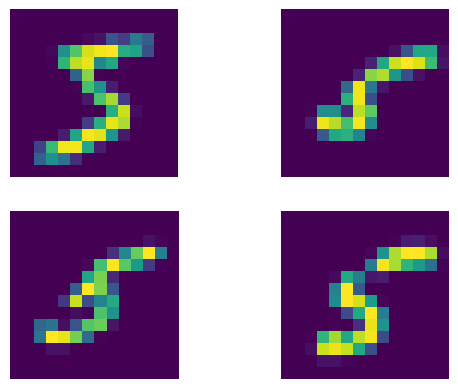

In [2]:
def load_idx(path: str) -> np.ndarray:
    with (gzip.open(path, 'rb') if path.endswith('.gz') else open(path, 'rb')) as f:
        idx_dtype, ndim = struct.unpack('BBBB', f.read(4))[2:]
        shape = struct.unpack('>' + 'I' * ndim, f.read(4 * ndim))
        buffer_length = int(np.prod(shape))
        return np.frombuffer(f.read(buffer_length), dtype=np.uint8).reshape(shape).astype(np.float32)
    
DATA_PATH = os.path.join(os.getcwd(), "../datasets/morphomnist/")
DIGIT = 5

raw_images = load_idx(os.path.join(DATA_PATH, "train-images-idx3-ubyte.gz"))
raw_images = skimage.measure.block_reduce(raw_images, block_size=(1, 2, 2))

raw_labels = load_idx(os.path.join(DATA_PATH, "train-labels-idx1-ubyte.gz"))
raw_metrics = pd.read_csv(os.path.join(DATA_PATH, "train-morpho.csv"), index_col= 'index')
raw_thickness = np.array(raw_metrics["thickness"])[..., None]
raw_intensity = np.array(raw_metrics["intensity"])[..., None]

digit_indices = (raw_labels == DIGIT) if DIGIT is not None else (raw_labels == raw_labels)

labels = torch.tensor(raw_labels[digit_indices]).to(torch.long).requires_grad_(False).detach()
images = torch.tensor(raw_images[np.broadcast_to(digit_indices[..., None, None], raw_images.shape)].reshape(-1, 1, *raw_images.shape[-2:])).to(torch.float32).requires_grad_(False).detach()
thickness = torch.tensor(raw_thickness[digit_indices]).to(torch.float32).requires_grad_(False).detach()
intensity = torch.tensor(raw_intensity[digit_indices]).to(torch.float32).requires_grad_(False).detach()

fig = plt.figure()
for i in range(4):
    fig.add_subplot(2, 2, i + 1)
    plt.imshow(images[i, 0])
    plt.axis('off')

## Model: deep structural causal model

The following code models morphological transformations of MNIST,
defining a causal generative model over digits that contains endogenous
variables to control the width $t$ and intensity $i$ of the stroke:

In [3]:
class ConstantParamTransformModule(dist.torch_transform.TransformModule):
    def __init__(self, transform: dist.transforms.Transform):
        super().__init__()
        self._transform = transform
        self.domain = transform.domain
        self.codomain = transform.codomain
        self.bijective = transform.bijective
        
    @property
    def sign(self):
        return self._transform.sign
        
    def _call(self, x):
        return self._transform(x)
    
    def _inverse(self, y):
        return self._transform.inv(y)
    
    def log_abs_det_jacobian(self, x, y):
        return self._transform.log_abs_det_jacobian(x, y)
    
    def with_cache(self, *args):
        return self._transform.with_cache(*args)


class ComposeTransformModule(dist.transforms.ComposeTransformModule):
    def __init__(self, transforms: List[dist.transforms.Transform]):
        super().__init__([
            ConstantParamTransformModule(t) if not isinstance(t, torch.nn.Module) else t for t in transforms
        ])

We model stroke thickness with a learnable univariate spline transformation of a standard normal distribution (defined later):

In [4]:
class ThicknessTransform(ComposeTransformModule):
    def __init__(self, thickness_size: int, weight: float, bias: float):
        self.thickness_size = thickness_size
        super().__init__([
            dist.transforms.Spline(thickness_size, bound=1.),
            dist.transforms.AffineTransform(loc=bias, scale=weight),
            dist.transforms.biject_to(dist.constraints.positive),
        ])

We use a similar approach to model the *conditional* distribution of stroke intensity *given* stroke thickness. The parameters of the univariate spline transformation are not left free, but are themselves a learnable function of thickness. We parameterize this second learnable function with a small multilayer perceptron:

In [4]:
class IntensityTransform(dist.conditional.ConditionalComposeTransformModule):
    def __init__(
        self,
        intensity_size: int,
        thickness_size: int,
        hidden_dims: List[int],
        weight: float,
        bias: float,
        *,
        count_bins: int = 8,
        nonlinearity=torch.nn.ReLU(),
    ):
        self.intensity_size = intensity_size
        self.thickness_size = thickness_size
        self.hidden_dims = hidden_dims
        
        intensity_nn = pyro.nn.DenseNN(
            thickness_size,
            hidden_dims,
            param_dims=[
                intensity_size * count_bins,
                intensity_size * count_bins,
                intensity_size * (count_bins - 1),
                intensity_size * count_bins,
            ],
            nonlinearity=nonlinearity,
        )
        super().__init__([
            dist.transforms.ConditionalSpline(intensity_nn, intensity_size, count_bins),
            dist.transforms.AffineTransform(loc=bias, scale=weight),
            dist.transforms.SoftplusTransform(),
        ])

The transformation for the images is somewhat more involved. We will define it in two parts: an expressive unconditional transformation and a smaller conditional transformation, both of which are themselves composed of repeated blocks of autoregressive normalizing flows. Unlike the transforms for thickness and intensity, which were defined as maps from gaussian noise to data, our image transformation will be defined in the reverse direction, as a mapping from data to noise; the causal probabilistic program we write later on will define a distribution on images using the inverse of our definition here.

Much of the neural network architecture in the first, unconditional transformation is taken from [this excellent PyTorch tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial11/NF_image_modeling.html) on generative modelling of images with normalizing flows, which readers are encouraged to peruse for further background on normalizing flows in general and this architecture in particular. The only significant difference between the definitions of the unconditional image transform and its components in this notebook and the PyTorch tutorial above is that this notebook implements a `torch.distributions.Transform` interface for `MaskedAffineCouplingLayer`, making it fully compatible with Pyro models and inference algorithms. The code has also been tweaked to improve compatibility with Pyro's (ab)use of broadcasting in PyTorch.

In [ ]:
class DequantizationTransform(ComposeTransformModule):
    def __init__(self, alpha: float = 1e-5):
        layers = [
            dist.transforms.IndependentTransform(
                dist.transforms.ComposeTransform([
                    dist.transforms.AffineTransform(0., 1. / 256),
                    dist.transforms.AffineTransform(alpha, (1 - alpha)),
                    dist.transforms.SigmoidTransform().inv,
            ]), 3)
        ]
        super().__init__(layers)


class ConcatELU(torch.nn.Module):
    """
    Activation function that applies ELU in both direction (inverted and plain).
    Allows non-linearity while providing strong gradients for any input (important for final convolution)
    """
    def forward(self, x):
        return torch.cat([torch.nn.functional.elu(x), torch.nn.functional.elu(-x)], dim=-3)


class LayerNormChannels(torch.nn.Module):

    def __init__(self, c_in: int, eps: float = 1e-5):
        """
        This module applies layer norm across channels in an image.
        Inputs:
            c_in - Number of channels of the input
            eps - Small constant to stabilize std
        """
        super().__init__()
        self.gamma = torch.nn.Parameter(torch.ones(1, c_in, 1, 1))
        self.beta = torch.nn.Parameter(torch.zeros(1, c_in, 1, 1))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=-3, keepdim=True)
        var = x.var(dim=-3, unbiased=False, keepdim=True)
        y = (x - mean) / torch.sqrt(var + self.eps)
        y = y * self.gamma + self.beta
        return y


class GatedConv(torch.nn.Module):

    def __init__(self, c_in: int, c_hidden: int):
        """
        This module applies a two-layer convolutional ResNet block with input gate
        Inputs:
            c_in - Number of channels of the input
            c_hidden - Number of hidden dimensions we want to model (usually similar to c_in)
        """
        super().__init__()
        self.net = torch.nn.Sequential(
            ConcatELU(),
            torch.nn.Conv2d(2*c_in, c_hidden, kernel_size=3, padding=1),
            ConcatELU(),
            torch.nn.Conv2d(2*c_hidden, 2*c_in, kernel_size=1)
        )

    def forward(self, x):
        out = self.net(x)
        val, gate = out.chunk(2, dim=-3)
        return x + val * torch.sigmoid(gate)


class GatedConvNet(torch.nn.Module):

    def __init__(self, c_in: int, c_hidden: int, num_layers: int, eps: float = 1e-5):
        """
        Module that summarizes the previous blocks to a full convolutional neural network.
        Inputs:
            c_in - Number of input channels
            c_hidden - Number of hidden dimensions to use within the network
            c_out - Number of output channels.
            num_layers - Number of gated ResNet blocks to apply
        """
        super().__init__()
        c_out = 2 * c_in
        layers = []
        layers += [torch.nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)]
        for layer_index in range(num_layers):
            layers += [
                GatedConv(c_hidden, c_hidden),
                LayerNormChannels(c_hidden, eps=eps)
            ]
        layers += [
            ConcatELU(),
            torch.nn.Conv2d(2*c_hidden, c_out, kernel_size=3, padding=1)
        ]
        self.nn = torch.nn.Sequential(*layers)

        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()

    def forward(self, x):
        return self.nn(x)


class MaskedAffineCouplingLayer(dist.torch_transform.TransformModule):
    bijective = True
    domain = dist.constraints.independent(dist.constraints.real, 3)
    codomain = dist.constraints.independent(dist.constraints.real, 3)

    def __init__(self, network: torch.nn.Module, mask: torch.Tensor, c_in: int, h: int, w: int):
        """
        Coupling layer inside a normalizing flow.
        Inputs:
            network - A PyTorch nn.Module constituting the deep neural network for mu and sigma.
                      Output shape should be twice the channel size as the input.
            mask - Binary mask (0 or 1) where 0 denotes that the element should be transformed,
                   while 1 means the latent will be used as input to the NN.
            c_in - Number of input channels
        """
        self.c_in = c_in
        self.h = h
        self.w = w
        super().__init__()
        self.network = network
        self.scaling_factor = torch.nn.Parameter(torch.zeros(c_in, device=mask.device))
        self.register_buffer('mask', mask)
        
    def with_cache(self, *args):
        return self
        
    def _net(self, x):
        net_flat_shape = (-1,) + x.shape[-3:]
        net_out_shape = x.shape[:-3] + (-1,) + x.shape[-2:]
        s, t = self.network(x.reshape(net_flat_shape) * self.mask).reshape(net_out_shape).chunk(2, dim=-3)

        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac

        # Mask outputs (only transform parts where self.mask == 0)
        return s * (1 - self.mask), t * (1 - self.mask)
        
    def log_abs_det_jacobian(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        s, _ = self._net(x)
        return s.sum(dim=[-1,-2,-3])
    
    def _inverse(self, y: torch.Tensor) -> torch.Tensor:
        s, t = self._net(y)
        return (y * torch.exp(-s)) - t
    
    def _call(self, x: torch.Tensor) -> torch.Tensor:
        s, t = self._net(x)
        return (x + t) * torch.exp(s)


class UnconditionalImageTransform(ComposeTransformModule):
    def __init__(
        self,
        im_size: int,
        input_channels: int,
        thickness_size: int,
        intensity_size: int,
        num_blocks: int,
        layers_per_block: int,
        hidden_channels: int,
        *,
        alpha: float = 1e-5,
        ln_momentum: float = 1e-5,
    ):
        self.im_size = im_size
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.num_blocks = num_blocks
        self.layers_per_block = layers_per_block
        
        layers = []
        
        # dequantization
        layers += [DequantizationTransform(alpha=alpha)]
        
        for i in range(num_blocks):
            layers += [
                MaskedAffineCouplingLayer(
                    GatedConvNet(input_channels, hidden_channels, layers_per_block, eps=ln_momentum),
                    self.create_checkerboard_mask(im_size, im_size, invert=(i%2==1)),
                    input_channels,
                    im_size,
                    im_size,
                ),
            ]
            
        super().__init__(layers)

    @staticmethod
    def create_checkerboard_mask(h: int, w: int, invert=False):
        x, y = torch.arange(h, dtype=torch.int32), torch.arange(w, dtype=torch.int32)
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        mask = torch.fmod(xx + yy, 2).to(torch.float32).view(1, 1, h, w)
        return mask if not invert else (1. - mask)    

The unconditional generative flow above is compact and expressive enough to learn a high-quality approximation to the high-dimensional data distribution. However, to represent conditional distributions over images, we must compose it with a second transformation that is conditionally invertible given an arbitrary context vector.

Pyro comes with a number of conditional transforms that are suitable for this task. In this example, we will use a series of `ConditionalAffineAutoRegressive` transforms because of their relative simplicity, speed, and stability during training. Detailed explanations of their internals are beyond the scope of this notebook; readers seeking more background information about these transformations should consult the Pyro documentation and source code for `ConditionalAffineAutoRegressive`, `ConditionalAutoRegressiveNN` and related functionality.

In [ ]:
class ConditionalImageTransform(dist.conditional.ConditionalComposeTransformModule):
    def __init__(
        self,
        im_size: int,
        input_channels: int,
        thickness_size: int,
        intensity_size: int,
        num_cond_blocks: int,
        *,
        nonlinearity = torch.nn.ReLU(),
    ):
        self.im_size = im_size
        self.input_channels = input_channels
        self.num_cond_blocks = num_cond_blocks
        self.flat_input_size = input_channels * im_size * im_size
        
        layers = []
        layers += [dist.transforms.ReshapeTransform((input_channels, im_size, im_size), (self.flat_input_size,))]
        for i in range(self.num_cond_blocks):
            layers += [
                dist.transforms.ConditionalAffineAutoregressive(
                    pyro.nn.ConditionalAutoRegressiveNN(
                        self.flat_input_size,
                        thickness_size + intensity_size,
                        [2 * self.flat_input_size] * 2,
                        nonlinearity=nonlinearity,
                        skip_connections=True,
                    ),
                ),
            ]  
        layers += [dist.transforms.ReshapeTransform((self.flat_input_size,), (input_channels, im_size, im_size))]
        super().__init__(layers)

Having defined `UnconditionalImageTransform` and `ConditionalImageTransform`, we can compose them into the full conditionally invertible transformation we will be using in our causal model:

In [ ]:
class ImageTransform(dist.conditional.ConditionalComposeTransformModule):
    def __init__(
        self,
        im_size: int,
        input_channels: int,
        thickness_size: int,
        intensity_size: int,
        num_blocks: int,
        layers_per_block: int,
        hidden_channels: int,
        *,
        num_cond_blocks: int = 1,
        alpha: float = 1e-5,
        ln_momentum: float = 1e-5,
        nonlinearity = torch.nn.ReLU(),
    ):
        self.im_size = im_size
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.num_blocks = num_blocks
        self.layers_per_block = layers_per_block
        self.num_cond_blocks = num_cond_blocks
        self.flat_input_size = input_channels * im_size * im_size
        
        layers = []

        # unconditional image flow: dequantization followed by convolutional blocks
        layers += [UnconditionalImageTransform(
            im_size=im_size,
            input_channels=input_channels,
            thickness_size=thickness_size,
            intensity_size=intensity_size,
            num_blocks=num_blocks,
            layers_per_block=layers_per_block,
            hidden_channels=hidden_channels,
            alpha=alpha,
            ln_momentum=ln_momentum,
        )]
            
        # conditioning on context with conditional autoregressive flows
        layers += [ConditionalImageTransform(
            im_size=im_size,
            input_channels=input_channels,
            thickness_size=thickness_size,
            intensity_size=intensity_size,
            num_cond_blocks=num_cond_blocks,
            nonlinearity=nonlinearity,
        )]
        
        super().__init__(layers)

With all of these components defined, we can finally define the high-level causal model we'll be using:

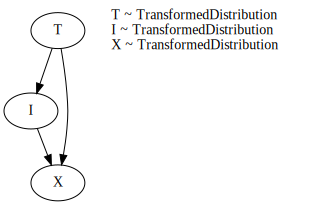

In [6]:
class DeepSCM(pyro.nn.PyroModule):
    
    thickness_support = dist.constraints.positive
    intensity_support = dist.constraints.positive

    def __init__(
        self,
        thickness_transform: ThicknessTransform,
        intensity_transform: IntensityTransform,
        image_transform: ImageTransform,
        *,
        include_thickness: bool = True,
        include_intensity: bool = True,
        include_image: bool = True,
    ):
        super().__init__()
        # mechanisms
        self.thickness_transform = thickness_transform
        self.intensity_transform = intensity_transform
        self.image_transform = image_transform.inv  # generative direction is inverse
        
        # base dist buffers
        self.register_buffer("base_loc", torch.tensor(0.))
        self.register_buffer("base_scale", torch.tensor(1.))

        # tensor sizes
        self.thickness_size = self.thickness_transform.thickness_size
        self.intensity_size = self.intensity_transform.intensity_size
        self.im_size = self.image_transform._transform.im_size
        self.im_input_channels = self.image_transform._transform.input_channels

    def StandardNormal(self, *event_shape: int) -> Union[dist.Independent, dist.Normal]:
        return dist.Normal(self.base_loc, self.base_scale).expand(event_shape).to_event(len(event_shape))
    
    @staticmethod
    def cond_dist(
        transform: Union[dist.transforms.Transform, dist.conditional.ConditionalTransform],
        U_dist: dist.Distribution,
        *contexts: torch.Tensor
    ) -> dist.Distribution:
        if contexts:
            batch_shape = torch.broadcast_shapes(*(c.shape[:-1] for c in contexts))
            U_dist = U_dist.expand(torch.broadcast_shapes(batch_shape, U_dist.batch_shape))
            context = torch.cat([c.expand(batch_shape + (-1,)) for c in contexts], dim=-1)
            transform = transform.condition(context)
        return dist.TransformedDistribution(U_dist, transform)

    def forward(self):
        # Thickness:
        UT_dist = self.StandardNormal(self.thickness_size)
        T_dist = self.cond_dist(self.thickness_transform, UT_dist)
        T = pyro.sample("T", T_dist)
        T_unconstrained = dist.transforms.biject_to(self.thickness_support).inv(T)

        # Intensity:
        UI_dist = self.StandardNormal(self.intensity_size)
        I_dist = self.cond_dist(self.intensity_transform, UI_dist, T_unconstrained)
        I = pyro.sample("I", I_dist)
        I_unconstrained = dist.transforms.biject_to(self.intensity_support).inv(I)

        # Image:
        UX_dist = self.StandardNormal(self.im_input_channels, self.im_size, self.im_size)
        X_dist = self.cond_dist(self.image_transform, UX_dist, T_unconstrained, I_unconstrained)
        X = pyro.sample("X", X_dist)

        return X

thickness_transform = ThicknessTransform(
    thickness.shape[-1],
    weight=thickness.log().mean().detach().item(),
    bias=thickness.log().std().detach().item(),
)

intensity_transform = IntensityTransform(
    intensity.shape[-1],
    thickness.shape[-1],
    hidden_dims=[16],
    weight=intensity.min().detach().item(),
    bias=(intensity.max() - intensity.min()).detach().item(),
    nonlinearity=torch.nn.ELU(),
    count_bins=4,
)

image_transform = ImageTransform(
    images.shape[-1],
    1,
    thickness.shape[-1],
    intensity.shape[-1],
    num_blocks=8,
    layers_per_block=3,
    hidden_channels=16,
    nonlinearity=torch.nn.ELU(),
)

model = DeepSCM(thickness_transform, intensity_transform, image_transform)
pyro.render_model(model, render_distributions=True)

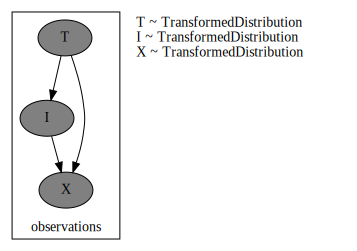

In [7]:
class ConditionedDeepSCM(pyro.nn.PyroModule):
    def __init__(self, model: DeepSCM):
        super().__init__()
        self.model = model
        
    def forward(self, t_obs, i_obs, x_obs):
        with condition(data={"X": x_obs, "T": t_obs, "I": i_obs}), \
                pyro.poutine.scale(scale=1 / x_obs.shape[0]), \
                pyro.plate("observations", size=x_obs.shape[0], dim=-1):
            return self.model()

conditioned_model = ConditionedDeepSCM(model)
pyro.render_model(conditioned_model, model_args=(thickness[:2], intensity[:2], images[:2]), render_distributions=True)

In [8]:
adam_params = {"lr": 1e-3}
batch_size = 128
num_epochs = 100

class LightningSVI(pl.LightningModule):
    def __init__(self, model: ConditionedDeepSCM, guide: pyro.nn.PyroModule, elbo: pyro.infer.ELBO, optim_params: dict):
        super().__init__()
        self.model = model
        self.guide = guide
        self.elbo = elbo(self.model, self.guide)
        self._optim_params = optim_params

    def training_step(self, batch, batch_idx):
        t_obs, i_obs, x_obs = batch
        x_obs = x_obs + torch.rand_like(x_obs)
        loss = self.elbo(t_obs, i_obs, x_obs)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.elbo.parameters(), **self._optim_params)
        return optimizer
        
guide = pyro.infer.autoguide.AutoDelta(conditioned_model)
elbo = pyro.infer.Trace_ELBO()
lightning_svi = LightningSVI(conditioned_model, guide, elbo, adam_params)

dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(thickness, intensity, images),
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
)

trainer = pl.Trainer(
    max_epochs=num_epochs,
    gradient_clip_val=1.0,
    accelerator="gpu",
    default_root_dir=os.path.join("./lightning_logs/deepscm_ckpt", "deepscm_joint"),
    callbacks=[
        pl.callbacks.ModelCheckpoint(save_weights_only=True, mode="min", monitor="train_loss"),
    ],
)

try:
    state_path = os.path.join("./lightning_logs/deepscm_ckpt", "deepscm_joint", "lightning_logs", "version_114", "checkpoints", "epoch=47-step=2064.ckpt")
    lightning_svi.load_state_dict(torch.load(state_path)["state_dict"])
    lightning_svi.eval()
except FileNotFoundError:
    trainer.fit(model=lightning_svi, train_dataloaders=dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


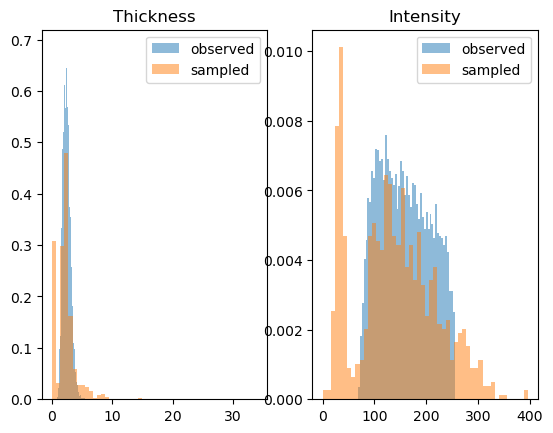

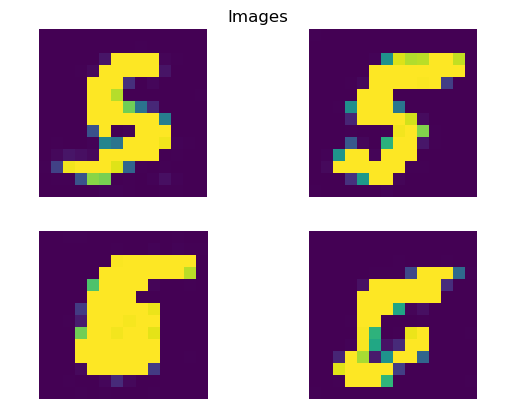

In [9]:
predictive = pyro.infer.Predictive(model, guide=lambda *args: None, num_samples=1000, parallel=True).to(device=torch.device("cpu"))
samples = predictive()

fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.hist(thickness[..., 0], bins=50, alpha=0.5, density=True, label="observed")
plt.hist(samples["T"][..., 0].squeeze(), bins=50, alpha=0.5, density=True, label="sampled")
plt.title("Thickness")
plt.legend()

fig.add_subplot(1, 2, 2)
plt.hist(intensity[..., 0], bins=50, alpha=0.5, density=True, label="observed")
plt.hist(samples["I"][..., 0].squeeze(), bins=50, alpha=0.5, density=True, label="sampled")
plt.title("Intensity")
plt.legend()

fig = plt.figure()
plt.title("Images")
plt.axis("off")
for i in range(2 * 2):
    fig.add_subplot(2, 2, i + 1)
    plt.imshow(samples["X"][i].squeeze())
    plt.axis("off")

## Causal Query: counterfactual data generation

Now that we've defined our deep SCM model and trained the neural network parameters on observed data, we can start asking interesting causal questions. Specifically, we are interested in the *counterfactual* question: "given an observed digit $X$, what would the digit have been had $t$ been $t + 1$?" As we discussed earlier, this question about changes to a specific instance (here a single image) is different from the more typical questions about changes across a population of instances.

One approach for answering these kinds of counterfactual quantities is to use Pearl's three step approach \[Pearl 2011\] we discussed earlier:

1. **Abduction** -  Infer the (posterior distribution over) exogenous noise terms given factual observations,
2. **Action** - Apply an intervention to our causal model, and
3. **Prediction** - Simulate from our intervened causal model using the inferred exogenous noise terms from 1.

However, we can equivalently represent this process with inference in a single, expanded probabilistic program containing two copies of every deterministic statement (a so-called \"twin network\" representation of counterfactuals, first described in Chapter 7 of \[Pearl 2009\] and extended to the PPL setting in \[Tavares, 2020\]). In previous examples and tutorials these twin worlds shared only causal model parameters, but in this case the twin worlds also share exogenous noise terms, enabling unit-level counterfactual reasoning. In a future tutorial we will elaborate on how and why models using `TransformedDistribution`s share noise across counterfactual worlds, and how this differs from all other examples and tutorials.

**Note:** In the case of deterministic structural causal models, as in this model, the abduction step reduces to inverting the neural network function.



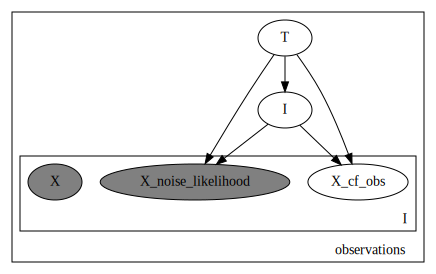

In [10]:
class CounterfactualDeepSCM(pyro.nn.PyroModule):
    def __init__(self, model: DeepSCM):
        super().__init__()
        self.model = model
        
    def forward(self, x_obs: torch.Tensor, i_act: Optional[torch.Tensor], t_act: Optional[torch.Tensor]):
        assert i_act is not None or t_act is not None
        with MultiWorldCounterfactual(), \
                pyro.plate("observations", size=x_obs.shape[0], dim=-1), \
                do(actions={"I": i_act}) if i_act is not None else contextlib.nullcontext(), \
                do(actions={"T": t_act}) if t_act is not None else contextlib.nullcontext(), \
                condition(data={"X": x_obs}):
            return gather(self.model(), IndexSet(I={1}, T={1}), event_dim=3)

cf_model = CounterfactualDeepSCM(model)
pyro.render_model(cf_model, model_args=(images[:1], intensity[:1], None))

Counterfactuals cannot be identified from observational data in general
without further assumptions: learning parameters $\theta$ that match
observed data does not guarantee that the counterfactual distribution
will match that of the true causal model. However, as discussed in e.g. the
original paper [Pawlowski et al. (2020)] in the context of modeling MRI
images, there are a number of valid practical reasons one might wish to
compute counterfactuals with a model anyway, such as explanation or expert evaluation.

It just so happens that the data generating process for our images of handwritten digits has enough additional structure (specifically, one-dimensional covariates with monotonic mechanisms) that recovering approximations of the causal mechanisms from observational data may not be impossible in theory.
In the following pair of plots, we experimentally interrogate our trained model's causal knowledge by visualizing counterfactual images sampled from the model.

The leftmost entry of each row is an image from the training dataset, followed by several counterfactual sample images drawn from the model given the original image and an intervention on one of the two covariates, with the other covariate held fixed at its observed value.

The intervened values (intensity in the first plot, thickness in the second) for the samples in each row are monotonically increasing from left to right, starting from their ground truth observed values for the training image in that row. Successive samples in a row are shown alongside their pixelwise differences with their neighbors.

In the first plot below, we can see stroke intensity increasing monotonically from left to right while the stroke thickness remains roughly constant.

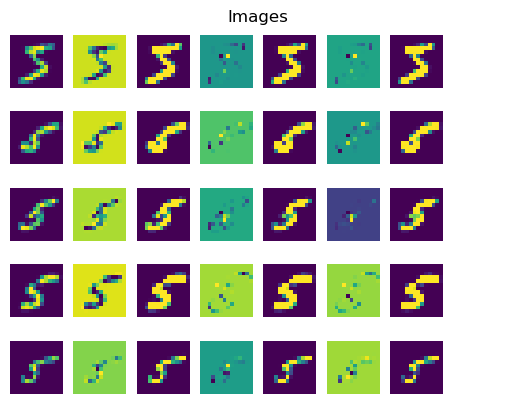

In [13]:
num_data, num_samples = 5, 4

observed_images = images[:num_data]
intervened_intensity = torch.linspace(10., 360., num_samples)[..., None]
intervened_thickness = torch.linspace(0.1, 8., num_samples)[..., None]

cf_predictive = pyro.infer.Predictive(cf_model, guide=lambda *args: None, num_samples=10, parallel=True).to(device=torch.device("cpu"))
samples = cf_predictive(observed_images, intervened_intensity[0:1], None)

fig = plt.figure()
plt.title("Images")
plt.axis("off")
for i in range(num_data):
    fig.add_subplot(num_data, 2 * num_samples, 2 * num_samples * i + 1)
    plt.imshow(samples["X"].mean(0)[0, i].squeeze())
    plt.axis("off")
    
    cf_prev = samples["X"][:, 0:1, i:i+1]
    for s in range(1, num_samples):
        cf_samples = cf_predictive(observed_images[i:i+1], intervened_intensity[s:s+1], None)["X"]
        cf_diff, cf_prev = cf_samples - cf_prev, cf_samples
        fig.add_subplot(num_data, 2 * num_samples, 2 * num_samples * i + 1 + 2 * s - 1)
        plt.imshow(cf_diff.mean(0)[1].squeeze())
        plt.axis("off")
        fig.add_subplot(num_data, 2 * num_samples, 2 * num_samples * i + 1 + 2 * s)
        plt.imshow(cf_samples.mean(0)[1].squeeze())
        plt.axis("off")

In the second plot, we can see the images' stroke thickness increasing monotonically from left to right in each row, while their stroke intensity remains roughly constant.

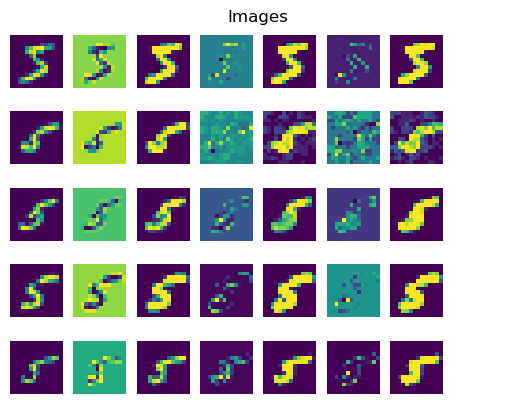

In [15]:
num_data, num_samples = 5, 4

observed_images = images[:num_data]
intervened_intensity = torch.linspace(10., 360., num_samples)[..., None]
intervened_thickness = torch.linspace(0.5, 6., num_samples)[..., None]

cf_predictive = pyro.infer.Predictive(cf_model, guide=lambda *args: None, num_samples=10, parallel=True).to(device=torch.device("cpu"))
samples = cf_predictive(observed_images, None, intervened_thickness[0:1])

fig = plt.figure()
plt.title("Images")
plt.axis("off")
for i in range(num_data):
    fig.add_subplot(num_data, 2 * num_samples, 2 * num_samples * i + 1)
    plt.imshow(samples["X"].mean(0)[0, i].squeeze())
    plt.axis("off")
    
    cf_prev = samples["X"][:, 0:1, i:i+1]
    for s in range(1, num_samples):
        cf_samples = cf_predictive(observed_images[i:i+1], None, intervened_thickness[s:s+1])["X"]
        cf_diff, cf_prev = cf_samples - cf_prev, cf_samples
        fig.add_subplot(num_data, 2 * num_samples, 2 * num_samples * i + 1 + 2 * s - 1)
        plt.imshow(cf_diff.mean(0)[1].squeeze())
        plt.axis("off")
        fig.add_subplot(num_data, 2 * num_samples, 2 * num_samples * i + 1 + 2 * s)
        plt.imshow(cf_samples.mean(0)[1].squeeze())
        plt.axis("off")

These qualitative results suggest that our deep generative model has indeed managed to approximately disentangle and recover the causal mechanisms of stroke thickness and intensity.

## References

Bareinboim, Elias, Juan Correa, Duligur Ibeling, and Thomas Icard. “On Pearl’s Hierarchy and the Foundations of Causal Inference (1st Edition).” In Probabilistic and Causal Inference: The Works of Judea Pearl, edited by Hector Geffner, Rina Dechter, and Joseph Y. Halpern, 507–56. ACM Books, 2022.

Pearl, Judea. Causality: Models, Reasoning and Inference. 2nd ed. USA: Cambridge University Press, 2009.

Pawlowski, Nick, Daniel C Castro, and Ben Glocker. “Deep Structural Causal Models for Tractable Counterfactual Inference.” ArXiv Preprint ArXiv:2006.06485, 2020.

Castro, Daniel C., Jeremy Tan, Bernhard Kainz, Ender Konukoglu, and Ben Glocker. “Morpho-MNIST: Quantitative Assessment and Diagnostics for Representation Learning.” arXiv, October 24, 2019. http://arxiv.org/abs/1809.10780.

Pearl, Judea. “The Algorithmization of Counterfactuals.” Annals of Mathematics and Artificial Intelligence 61, no. 1 (2011): 29–39.

Tavares, Zenna, James Koppel, Xin Zhang, and Armando Solar-Lezama. “A Language for Counterfactual Generative Models.” MIT Technical Report, 2020. http://www.jameskoppel.com/publication/omega/.


